In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
df = pd.read_pickle("datasets/text_dataset.pickle")
df.dropna(inplace=True)
df['full_text'] = df['task1_text'] + " " + df['task2_text'] + " " + df['task3_text']
df['tokens'] = (df['full_text']).apply(lambda text: text.split(" "))
df['words_number'] = df['tokens'].apply(len)
df.drop(df[df['words_number']<10].index, inplace=True)

In [3]:
from sklearn.preprocessing import StandardScaler

def show_correlation(dist1, dist2):
    plt.xlabel(dist1.name)
    plt.ylabel(dist2.name)
    dist1, dist2 = np.array(dist1), np.array(dist2)
    plt.scatter(dist1, dist2)
    plt.show()
    standard_dist1 = StandardScaler().fit_transform(dist1.reshape(-1,1)).squeeze()
    standard_dist2 = StandardScaler().fit_transform(dist2.reshape(-1,1)).squeeze()
    print("Correlation:", np.corrcoef(standard_dist1, standard_dist2)[0,1])

In [4]:
def get_tfidf_score(corpus):
    total_tf = Counter()
    docs_tf = []
    idf = Counter()
    for text in corpus:
        doc_tf = Counter()
        for token in text:
            doc_tf[token] += 1
            total_tf[token] += 1
        for token in doc_tf:
            idf[token] += 1
        docs_tf.append(doc_tf)
        
    docs_tfidf = []
    for i, doc_tf in enumerate(docs_tf):
        doc_tfidf = Counter()
        for token, value in doc_tf.items():
            doc_tfidf[token] = value / idf[token]
        docs_tfidf.append(doc_tfidf)
        
    unique_score = []
    for doc_tf, doc_tfidf in zip(docs_tf, docs_tfidf):
        corr = 0
        norm = 0
        for tf_value, tfidf_value in zip(doc_tf.values(), doc_tfidf.values()):
            corr += tfidf_value
            norm += tf_value
        unique_score.append(corr / norm)
        
    return unique_score

In [5]:
df['tfidf_score'] = get_tfidf_score(df['tokens'])

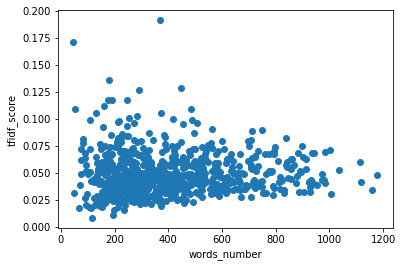

Correlation: 0.04094829920636601


In [6]:
show_correlation(df['words_number'], df['tfidf_score'])

In [7]:
import torch
import transformers
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_bert_score(corpus, mask_rate=0.1, runs=25):
    model_name = "DrMatters/rubert_cased"
    pretrained_name = 'pretrained_model'
    model = transformers.BertForMaskedLM.from_pretrained(pretrained_name)
    tokenizer = transformers.BertTokenizer.from_pretrained(model_name)
    
    losses = []
    for text in tqdm(corpus):
        total_loss = 0
        for _ in range(runs):
            tokens = tokenizer(text, padding=True, truncation=True, max_length=400, return_special_tokens_mask=True, return_tensors='pt')
            input_ids = tokens['input_ids']
            special_tokens_mask = tokens['special_tokens_mask'].byte()
            prob_tensor = torch.full(input_ids.size(), mask_rate)
            mask_tensor = torch.full(input_ids.size(), tokenizer.mask_token_id, dtype=torch.long)
            mask_text = torch.bernoulli(prob_tensor).byte()
            masked = torch.where(special_tokens_mask & mask_text, mask_tensor, input_ids)
            output = model(masked, labels=input_ids)
            total_loss += output.loss.item()
        losses.append(total_loss)

    return losses

/home/akkyma/anaconda3/envs/vosk/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/akkyma/anaconda3/envs/vosk/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/akkyma/anaconda3/envs/vosk/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/akkyma/anaconda3/envs/vosk/lib/python3.7/site-

In [8]:
df['bert_loss'] = get_bert_score(df['full_text'])

  4%|▍         | 33/745 [16:45<6:01:37, 30.47s/it]


KeyboardInterrupt: 

In [9]:
from nltk.lm import NgramCounter
from nltk.util import ngrams
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE

def get_ngram_score(corpus, n):
    train, vocab = padded_everygram_pipeline(n, corpus)
    lm = MLE(n)
    lm.fit(train, vocab)
    
    scores = []
    for text in corpus:
        if n > 1:
            text = ['<s>'] + text + ['</s>']
        score = 0
        for i in range(n-1, len(text)):
            word = text[i]
            context = text[i-(n-1): i]
            score += lm.logscore(word, context)
        score /= len(text)
        scores.append(score)
        
    return scores

In [10]:
df['ngram_score'] = get_ngram_score(df['tokens'], 3)

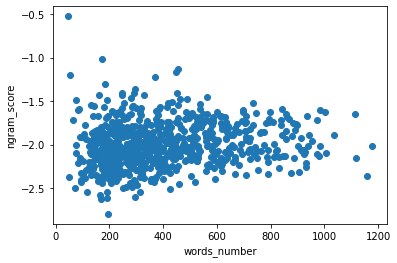

Correlation: 0.13196596809010486


In [11]:
show_correlation(df['words_number'], df['ngram_score'])

In [12]:
tfidf_sorted_df = df.sort_values('tfidf_score')
ngram_sorted_df = df.sort_values('ngram_score')

In [42]:
df['aggregate_order'] = 0
df.loc[tfidf_sorted_df.index, 'aggregate_order'] += range(len(df))
df.loc[ngram_sorted_df.index, 'aggregate_order'] += range(len(df))

In [72]:
order_sorted_df = df.sort_values('aggregate_order')
samples = 25
low_emails = order_sorted_df.iloc[:samples].email.values
high_emails = order_sorted_df.iloc[-samples:].email.values
random_emails = order_sorted_df.iloc[samples:-samples].email.sample(frac=1)[:samples].values

In [78]:
emails = np.concatenate([low_emails, random_emails, high_emails])
np.random.seed(42)
np.random.shuffle(emails)

In [81]:
import pickle

with open('emails.pickle', 'wb') as f:
    pickle.dump(emails, f)

In [93]:
from pathlib import Path
import shutil

source_dir = Path("data/audio")
dest_dir = Path("analyze_data")
dest_dir.mkdir(exist_ok=True)
for i, email in enumerate(emails):
    shutil.copytree(source_dir / email, dest_dir / ("%.2i" % i))